In [1]:
import pandas as pd
import networkx
import pickle
import json
from collections import defaultdict, Counter
import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2

with open('business_graph_threshold.pkl', 'rb') as f:
    G = pickle.load(f)

filtered_business_ids = set(G.nodes)

file_path = 'filtered_reviews_open2018_2019.csv'
filtered_reviews_df = pd.read_csv(file_path)

filtered_reviews_for_graph = filtered_reviews_df[filtered_reviews_df['business_id'].isin(filtered_business_ids)]

In [2]:
import networkx as nx
from networkx.algorithms.community import modularity
from collections import defaultdict

def extract_cuisine(categories):
    ignore_list = {"Restaurants", "Food"}
    if isinstance(categories, str):
        categories = categories.split(", ")
    for category in categories:
        if category not in ignore_list:
            return category
    return "Unknown" 

filtered_reviews_for_graph['cuisine'] = filtered_reviews_for_graph['categories'].apply(lambda x: extract_cuisine(x))

print(filtered_reviews_for_graph[['categories', 'cuisine']].head())

business_to_cuisine = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['cuisine']))

nx.set_node_attributes(G, business_to_cuisine, "cuisine")

cuisine_clusters = defaultdict(set)
for node, data in G.nodes(data=True):
    cuisine = data.get("cuisine", "Unknown")  # Default to "Unknown" if no cuisine is set
    cuisine_clusters[cuisine].add(node)

communities = list(cuisine_clusters.values())

all_nodes = set(G.nodes)
partition_nodes = set.union(*communities)
assert all_nodes == partition_nodes, "Partition does not cover all nodes!"

modularity_score = modularity(G, communities)
print("Modularity Score:", modularity_score)

/var/folders/8l/1xzphzy96ynfmykt3ln6dhdc0000gn/T/ipykernel_15408/1429228979.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_for_graph['cuisine'] = filtered_reviews_for_graph['categories'].apply(lambda x: extract_cuisine(x))


                                          categories     cuisine
0  Food, Desserts, Chocolatiers & Shops, Food Del...    Desserts
1  Bars, Moroccan, Wine Bars, Breakfast & Brunch,...        Bars
2  Soul Food, Southern, Comfort Food, Chicken Sho...   Soul Food
3  Sushi Bars, Restaurants, Japanese, Noodles, Ch...  Sushi Bars
6  Sandwiches, Restaurants, American (Traditional...  Sandwiches
Modularity Score: 0.18298067567991325


In [3]:
import networkx as nx
from networkx.algorithms.community import modularity

business_to_city = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['city']))

nx.set_node_attributes(G, business_to_city, "city")

from collections import defaultdict

city_clusters = defaultdict(list)
for node, data in G.nodes(data=True):
    city = data.get("city")
    if city:
        city_clusters[city].append(node)

communities = [set(nodes) for nodes in city_clusters.values()]

modularity_score = modularity(G, communities)
print("Modularity Score:", modularity_score)

Modularity Score: 0.4988362891206385


In [4]:
import community as community_louvain

partition = community_louvain.best_partition(G, random_state=42)

modularity_score = community_louvain.modularity(partition, G)

print(f"Modularity of the partition found by the Louvain algorithm: {modularity_score}")

Modularity of the partition found by the Louvain algorithm: 0.9481035411313181


100%|███████████████████████████████████████| 2000/2000 [03:14<00:00, 10.31it/s]


BarnesHut Approximation  took  82.90  seconds
Repulsion forces  took  101.89  seconds
Gravitational forces  took  0.68  seconds
Attraction forces  took  0.76  seconds
AdjustSpeedAndApplyForces step  took  3.21  seconds


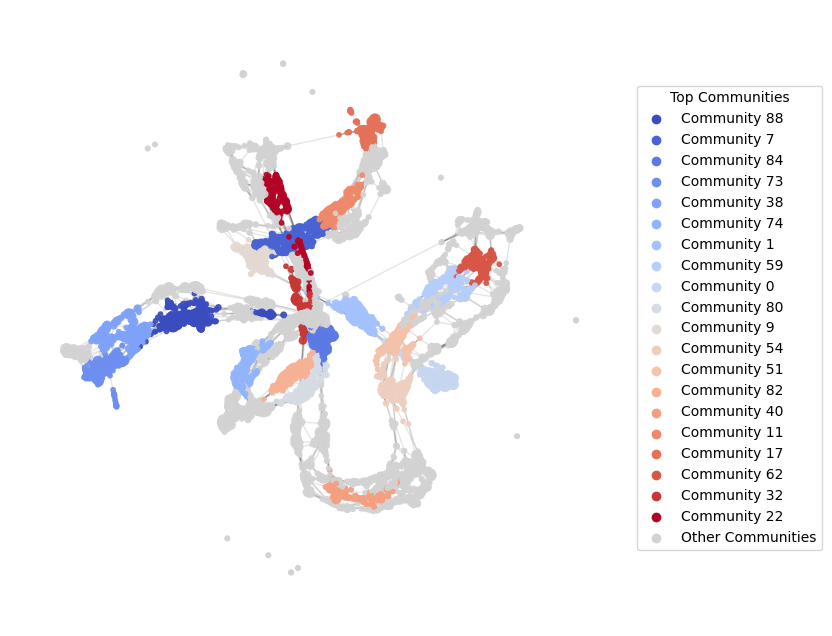

In [5]:
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=20.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

community_sizes = {}
for node, community in partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

top_communities = {community: i for i, (community, size) in enumerate(sorted_communities[:20])}

colors = plt.cm.get_cmap('coolwarm', len(top_communities))
node_colors = []

for node in G.nodes():
    community = partition[node]
    if community in top_communities:
        node_colors.append(colors(top_communities[community]))
    else:
        node_colors.append('lightgray')

node_degree = dict(G.degree())
node_sizes = [max(node_degree[node] * 2, 10) for node in G.nodes()]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, positions,
    edge_color='black',
    alpha=0.1
)

for community, idx in top_communities.items():
    plt.scatter([], [], c=[colors(idx)], label=f"Community {community}")

plt.scatter([], [], c='lightgray', label="Other Communities")

plt.legend(
    title="Top Communities",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.axis('off')
#plt.title("Network Graph with Communities (Cold to Warm Palette)", fontsize=16)
plt.savefig("louvain.png", format="png", dpi=600, bbox_inches='tight')
plt.show()

/var/folders/8l/1xzphzy96ynfmykt3ln6dhdc0000gn/T/ipykernel_15408/2821251563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews_for_graph['cuisine'] = filtered_reviews_for_graph['categories'].apply(lambda x: extract_cuisine(x))


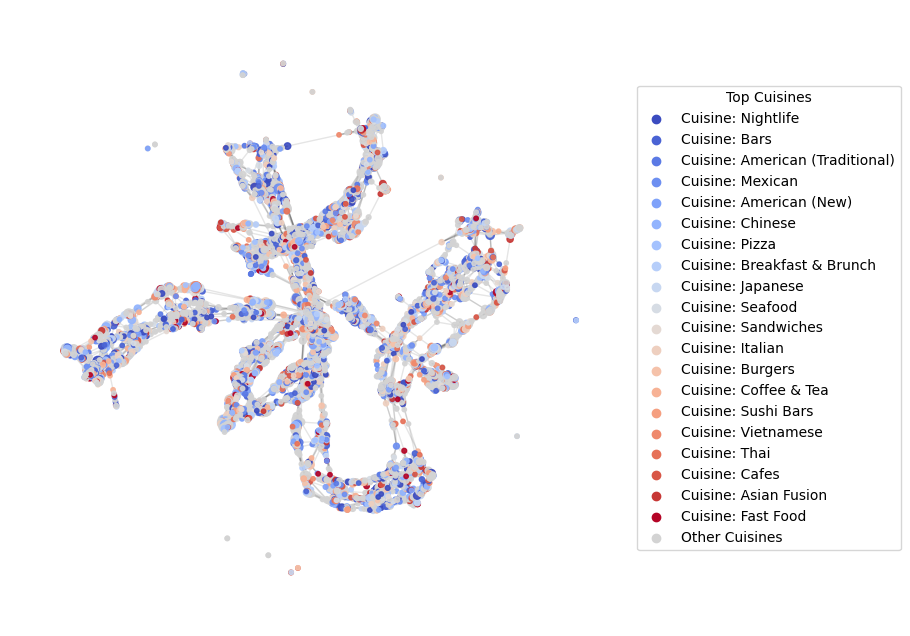

In [6]:
def extract_cuisine(categories):
    ignore_list = {"Restaurants", "Food"}
    if isinstance(categories, str):
        categories = categories.split(", ")
    for category in categories:
        if category not in ignore_list:
            return category
    return "Unknown"

filtered_reviews_for_graph['cuisine'] = filtered_reviews_for_graph['categories'].apply(lambda x: extract_cuisine(x))
business_to_cuisine = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['cuisine']))
nx.set_node_attributes(G, business_to_cuisine, "cuisine")

G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=20.0,
    verbose=True
)
#positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

cuisine_clusters = defaultdict(list)
for node, data in G.nodes(data=True):
    cuisine = data.get("cuisine")
    if cuisine:
        cuisine_clusters[cuisine].append(node)

communities = [set(nodes) for nodes in cuisine_clusters.values()]

cuisine_sizes = {cuisine: len(nodes) for cuisine, nodes in cuisine_clusters.items()}
sorted_cuisines = sorted(cuisine_sizes.items(), key=lambda x: x[1], reverse=True)

top_cuisines = {cuisine: i for i, (cuisine, size) in enumerate(sorted_cuisines[:20])}

colors = plt.cm.get_cmap('tab20', len(top_cuisines))
node_colors = []

for node in G.nodes():
    cuisine = G.nodes[node].get("cuisine")
    if cuisine in top_cuisines:
        node_colors.append(colors(top_cuisines[cuisine]))
    else:
        node_colors.append('lightgray')

node_sizes = [max(len(G[node]) * 2, 10) for node in G.nodes()]

colors = plt.cm.get_cmap('coolwarm', len(top_cuisines))
node_colors = []

for node in G.nodes():
    cuisine = G.nodes[node].get("cuisine")
    if cuisine in top_cuisines:
        node_colors.append(colors(top_cuisines[cuisine]))
    else:
        node_colors.append('lightgray')

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, positions,
    edge_color='black',
    alpha=0.1
)

for cuisine, idx in top_cuisines.items():
    plt.scatter([], [], c=[colors(idx)], label=f"Cuisine: {cuisine}")

plt.scatter([], [], c='lightgray', label="Other Cuisines")

plt.legend(
    title="Top Cuisines",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.axis('off')
plt.savefig("cuisines.png", format="png", dpi=600, bbox_inches='tight')
plt.show()

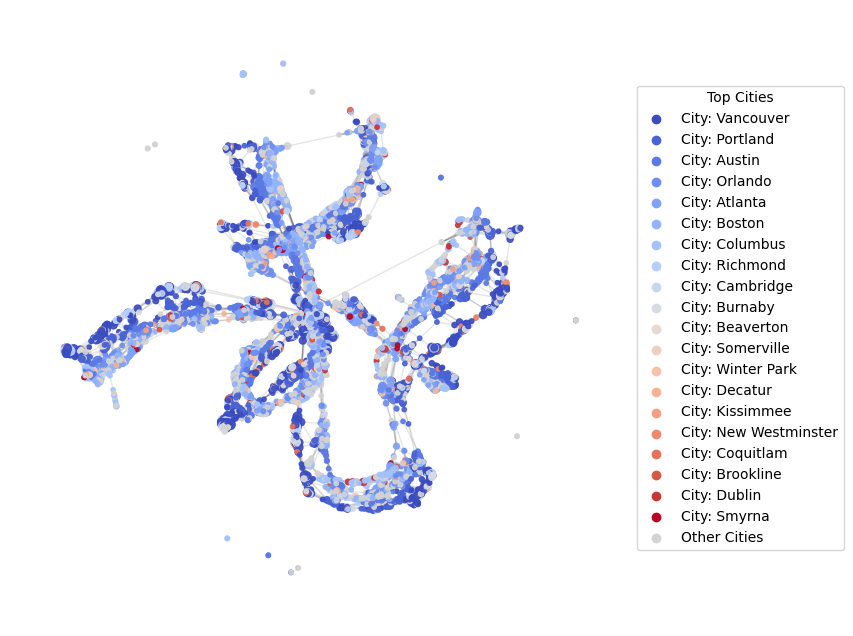

In [7]:
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=20.0,
    verbose=True
)
#positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

business_to_city = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['city']))
nx.set_node_attributes(G, business_to_city, "city")

city_clusters = defaultdict(list)
for node, data in G.nodes(data=True):
    city = data.get("city", "Unknown")
    city_clusters[city].append(node)

communities = [set(nodes) for nodes in city_clusters.values()]

city_sizes = {city: len(nodes) for city, nodes in city_clusters.items()}
sorted_cities = sorted(city_sizes.items(), key=lambda x: x[1], reverse=True)

top_cities = {city: i for i, (city, size) in enumerate(sorted_cities[:20])}

colors = plt.cm.get_cmap('coolwarm', len(top_cities))
node_colors = []

for node in G.nodes():
    city = G.nodes[node].get("city", "Unknown")
    if city in top_cities:
        node_colors.append(colors(top_cities[city]))
    else:
        node_colors.append('lightgray')

node_degree = dict(G.degree())
node_sizes = [max(node_degree[node] * 2, 10) for node in G.nodes()]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G, positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    alpha=0.9
)

nx.draw_networkx_edges(
    G, positions,
    edge_color='black',
    alpha=0.1
)

for city, idx in top_cities.items():
    plt.scatter([], [], c=[colors(idx)], label=f"City: {city}")

plt.scatter([], [], c='lightgray', label="Other Cities")

plt.legend(
    title="Top Cities",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.axis('off')
#plt.title("Network Graph by City Communities (Cold to Warm Palette)", fontsize=16)
plt.savefig("cities.png", format="png", dpi=600, bbox_inches='tight')
plt.show()

In [8]:
import community as community_louvain
from collections import defaultdict

louvain_partition = community_louvain.best_partition(G)

community_nodes = defaultdict(list)
for node, community in louvain_partition.items():
    community_nodes[community].append(node)

business_to_name = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['name']))

top_restaurants_per_community = {}
for community, nodes in community_nodes.items():
    ranked_nodes = sorted(nodes, key=lambda x: G.degree[x], reverse=True)
    top_business_ids = ranked_nodes[:5]
    top_restaurants_per_community[community] = [business_to_name.get(business_id, "Unknown") for business_id in top_business_ids]

for community, top_restaurants in top_restaurants_per_community.items():
    print(f"Community {community}: {top_restaurants}")

Community 0: ["Terry Black's Barbecue", "Gus's World Famous Fried Chicken", 'Moonshine Patio Bar & Grill', 'Hopdoddy Burger Bar', "Phoebe's Diner"]
Community 1: ["Mary Mac's Tea Room", 'Screen Door', 'Voodoo Doughnut - Old Town', "Poor Calvin's", 'The Cowfish Sushi Burger Bar']
Community 2: ['Min-Ga Korean Restaurant', 'Alchemy Café']
Community 3: ["Mike's Pastry", 'Atlanta Breakfast Club', 'The Salty Pig', 'King Bao', "Giacomo's Ristorante - Boston"]
Community 4: ['Downlow Chicken Shack', 'No 9 Restaurant', 'Atlas Steak + Fish', 'Samsoonie Noodle & Rice', 'Sushi Aji']
Community 7: ["Luke's Lobster Back Bay", 'Neptune Oyster', 'Pine State Biscuits', 'Bootleg Special', 'Pho Pasteur']
Community 8: ['Anh and Chi', "Chef's Playground Eatery", 'AFURI ramen + dumpling', 'Jam Cafe on Beatty', 'Phnom Penh']
Community 9: ["Bova's Bakery", 'Cafe Intermezzo - Midtown', 'Bostonia Public House', 'Barcelona Westside Ironworks', 'Mikado Japanese Seafood Buffet']
Community 10: ["Culver's - Austin", "T

In [9]:
import community as community_louvain
from collections import defaultdict

louvain_partition = community_louvain.best_partition(G)

community_nodes = defaultdict(list)
for node, community in louvain_partition.items():
    community_nodes[community].append(node)

business_to_city = dict(zip(filtered_reviews_for_graph['business_id'], filtered_reviews_for_graph['city']))

top_cities_per_community = {}
for community, nodes in community_nodes.items():
    city_counts = defaultdict(int)
    for node in nodes:
        city = business_to_city.get(node, "Unknown")
        city_counts[city] += 1
    ranked_cities = sorted(city_counts.items(), key=lambda x: x[1], reverse=True)
    top_cities_per_community[community] = ranked_cities[:5]

for community, top_cities in top_cities_per_community.items():
    print(f"Community {community}:")
    for city, count in top_cities:
        print(f"  {city}: {count} businesses")

Community 0:
  Austin: 40 businesses
  Portland: 27 businesses
  Vancouver: 25 businesses
  Atlanta: 24 businesses
  Boston: 14 businesses
Community 1:
  Atlanta: 32 businesses
  Austin: 31 businesses
  Portland: 30 businesses
  Orlando: 27 businesses
  Boston: 25 businesses
Community 2:
  Columbus: 2 businesses
Community 5:
  Atlanta: 73 businesses
  Austin: 49 businesses
  Orlando: 45 businesses
  Boston: 29 businesses
  Portland: 23 businesses
Community 4:
  Vancouver: 32 businesses
  Richmond: 18 businesses
  Coquitlam: 5 businesses
  Surrey: 3 businesses
  Burnaby: 2 businesses
Community 9:
  Orlando: 59 businesses
  Boston: 53 businesses
  Austin: 45 businesses
  Columbus: 35 businesses
  Portland: 27 businesses
Community 8:
  Portland: 49 businesses
  Vancouver: 44 businesses
  Richmond: 23 businesses
  Burnaby: 8 businesses
  Beaverton: 7 businesses
Community 10:
  Austin: 2 businesses
Community 11:
  Portland: 39 businesses
  Atlanta: 38 businesses
  Austin: 38 businesses
  Or